In [1]:
import sys

sys.path.append('../src/')

import matplotlib.pyplot as plt

import equinox as eqx
import jax.random as jr
import jax.nn as jnn
import jax.numpy as jnp
from ncpax.rnn import LiquidRNN, LTCCell, CfCCell
from jaxtyping import Array, PRNGKeyArray

key = jr.PRNGKey(12414)

In [2]:
class Params(eqx.Module):
    A: Array
    w_tau: Array
    sensory: eqx.nn.Linear
    hidden: eqx.nn.Linear
    sensory_size: int = eqx.field(static=True)
    hidden_size: int = eqx.field(static=True)
    motor_size: int = eqx.field(static=True)

    def __init__(self, sensory_size, hidden_size, motor_size, *, key: PRNGKeyArray ):
        self.sensory_size = sensory_size
        self.hidden_size = hidden_size
        self.motor_size = motor_size

        keys = jr.split(key)

        self.sensory = eqx.nn.Linear(sensory_size, hidden_size, use_bias=True, key=keys[0])
        self.hidden = eqx.nn.Linear(hidden_size, hidden_size, use_bias=True, key=keys[1])

        self.A = jnp.ones(hidden_size)
        self.w_tau = jnp.ones(hidden_size) * 1.

In [3]:
key, _key = jr.split(key)
def sensory_activation(input, affinemap):
    return jnn.sigmoid(affinemap(input))

def hidden_activation(constant, state, affinemap):
    r = affinemap(state) + constant
    return jnn.sigmoid(r)

input_size = 2
sensory_size = input_size
hidden_size = 20
motor_size = 2
output_size = 2
key, _key, lkey = jr.split(key, 3)
params = Params(sensory_size, hidden_size, motor_size, key=_key)
rnn_cell = LTCCell(params, sensory_activation, hidden_activation, ode_unfolds=16)

rnn = LiquidRNN(rnn_cell, input_size, output_size, key=lkey)

In [4]:
Δt = .1
ts = jnp.arange(0, 5 * jnp.pi, Δt)
inputs = jnp.stack([jnp.sin(ts), jnp.cos(ts)], -1)
init_hidden = jnp.zeros(hidden_size)
timespans = jnp.ones(len(inputs)) * Δt
output_sequence, last_hidden = rnn(inputs, init_hidden=init_hidden, timespans=timespans)

In [5]:
rnn_cell = CfCCell(params, sensory_activation, hidden_activation)

rnn = LiquidRNN(rnn_cell, input_size, output_size, key=lkey)
output_sequence_cfc, last_hidden_cfc = rnn(inputs, init_hidden=init_hidden, timespans=timespans)

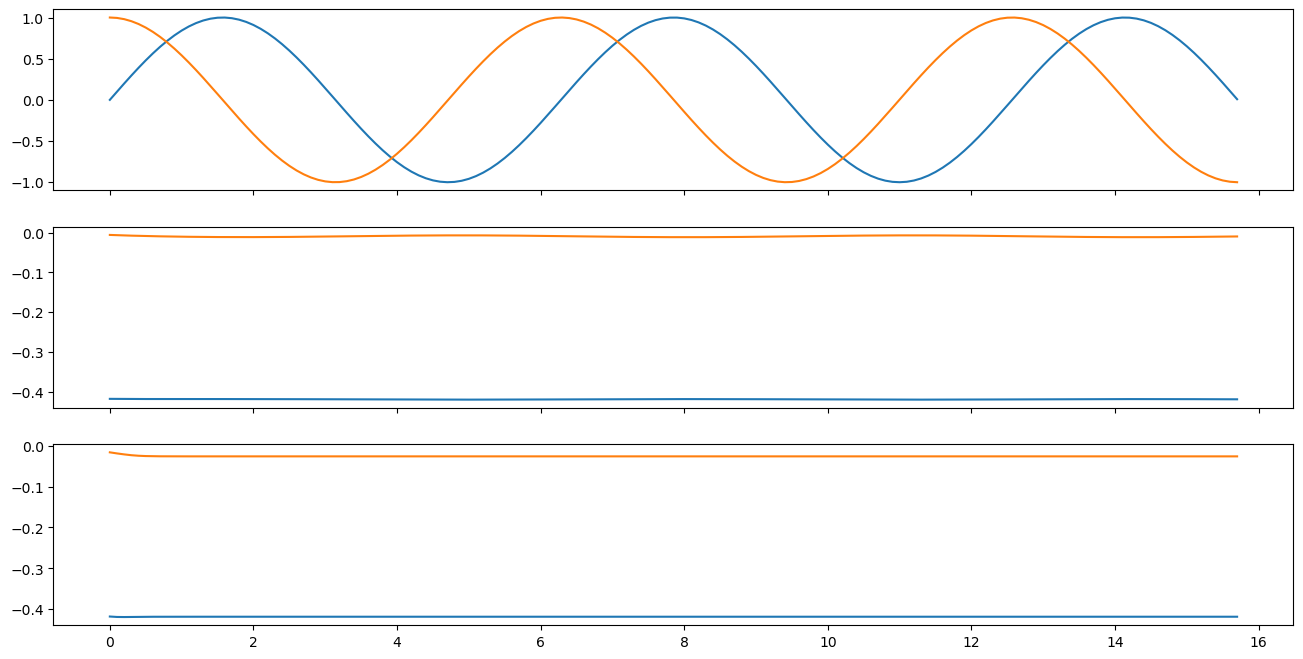

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
axes[0].plot(ts, inputs);
axes[1].plot(ts, output_sequence);
axes[2].plot(ts, output_sequence_cfc)

In [7]:
key, _key = jr.split(key)
def sensory_activation(input, affinemap):
    return affinemap(input)

def hidden_activation(constant, state, affinemap):
    return jnn.sigmoid(constant)

input_size = 2
sensory_size = input_size
hidden_size = 20
motor_size = 2
output_size = 2
key, _key, lkey = jr.split(key, 3)
params = Params(sensory_size, hidden_size, motor_size, key=_key)

In [8]:
tmp = jnp.pad(jnp.zeros(10, dtype=jnp.int16), (0, 10), constant_values=1)
inputs = jnn.one_hot(jnp.concatenate([tmp] * 5), 2)
inputs += jr.normal(_key, shape=(len(inputs), 2)) / 10
init_hidden = jnp.zeros(hidden_size)
timespans = jnp.ones(len(inputs)) * .05

In [9]:
rnn_cell = LTCCell(params, sensory_activation, hidden_activation, ode_unfolds=16)
rnn = LiquidRNN(rnn_cell, input_size, output_size, key=lkey)
output_sequence, last_hidden = rnn(inputs, init_hidden=init_hidden, timespans=timespans)

In [10]:
rnn_cell = CfCCell(params, sensory_activation, hidden_activation)
rnn = LiquidRNN(rnn_cell, input_size, output_size, key=lkey)
output_sequence_cfc, last_hidden_cfc = rnn(inputs, init_hidden=init_hidden, timespans=timespans)

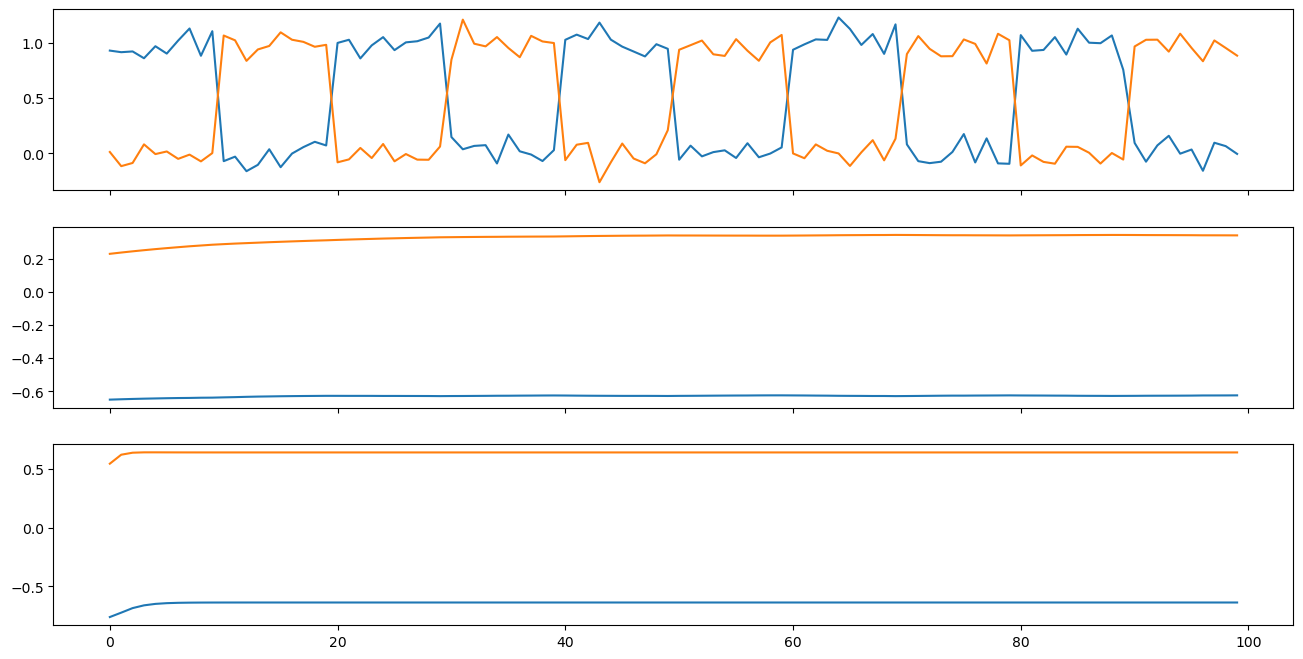

In [11]:
fig, axes = plt.subplots(3, 1, figsize=(16, 8), sharex=True)
axes[0].plot(inputs);
axes[1].plot(output_sequence);
axes[2].plot(output_sequence_cfc);